## Agent with Memory

Let's add a `MemorySaver` to retain previous results, enabling actions based on prior outputs.

---

installing core dependencies

In [1]:
%%capture --no-stderr
%pip install -q langchain_google_genai langchain_core langgraph langchain_community

If you're using google colab so load environment in that way

In [ ]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GEMINI_API_KEY')

if you're working locally so you need to load environment in that way

In [2]:
%%capture --no-stderr
%pip install python-dotenv

create `.env` file in project directory

In [3]:
from dotenv import load_dotenv
import os

load_dotenv()  # Load variables from .env file

os.environ['GOOGLE_API_KEY'] = os.getenv('GOOGLE_API_KEY')

I'm using Gemini Model, so you can use what you like, make sure to install langchain specific package for require Model, and set `API_KEY` accordingly

- Now Initializing Gemini LLM

In [4]:
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temprature=0)

#### Creating Tools for Use with LLMs

In [5]:

# Please add DOCSTRING to the function, so LLM can understand the function
def multiply(a: int, b: int) -> int:
    """
    Multiplies two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The product of the two integers.

    Example:
        >>> multiply(3, 4)
        12
        >>> multiply(-2, 5)
        -10
    """
    return a * b


def divide(a: int, b: int) -> float:
    """
    Divides two integers and returns the result.

    Args:
        a (int): The dividend.
        b (int): The divisor.

    Returns:
        float: The quotient of the two integers.

    Example:
        >>> divide(10, 2)
        5.0
        >>> divide(5, 2)
        2.5
    """
    return a / b

def add(a: int, b: int) -> int:
    """
    Adds two integers and returns the result.

    Args:
        a (int): The first integer.
        b (int): The second integer.

    Returns:
        int: The sum of the two integers.

    Example:
        >>> add(3, 4)
        7
        >>> add(-2, 5)
        3
    """
    return a + b

Binding this tool with an LLM.

In [ ]:
tools = [multiply, divide, add]
llm_with_tools = llm.bind_tools(tools)

#### Building the Graph with LangGraph

In [13]:
from langgraph.graph.state import StateGraph, CompiledStateGraph, START
from langgraph.graph.message import MessagesState
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.checkpoint.memory import MemorySaver

# if you're just working with messages so use prebuilt `MessagesState` by langgraph, other wise you can create your own state
builder: StateGraph = StateGraph(MessagesState)

creating node for graph

In [14]:
system_msg = SystemMessage("You are a helpfull assistant tasked with performing artithmetic operations on a set of inputs.")

def assistant(state:MessagesState) -> MessagesState:
    return {'messages': [llm_with_tools.invoke([system_msg] + state['messages'])]}

While creating the graph, ensure you include your tools using `ToolNode`. Add a conditional edge: if the context is not related to tool calling, the system should move to the end node; otherwise, it will proceed to call the tool.

In [15]:
# Adding Nodes
builder.add_node('assistant', assistant)
builder.add_node('tools', ToolNode(tools))

# Adding Edges
builder.add_edge(START, 'assistant')
builder.add_conditional_edges('assistant', tools_condition)

# this will back to the assistant node after the tool is executed
builder.add_edge('tools', 'assistant')

# let's add the memory to the graph
memory = MemorySaver() # Excersise #3: Main Task

# Compiling the graph and add memory in checkpointer
graph: CompiledStateGraph = builder.compile(checkpointer=memory)

##### Displaying the Graph Structure

The following code visualizes the compiled graph using Mermaid PNG

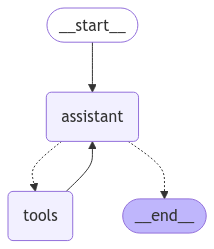

In [16]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

Now, I need to pass a context that can execute a tool. Then, I'll invoke the graph again to calculate values based on the previous result. 

Without using `MemorySaver`, the previous thread value can't be retained. Therefore, we need to ensure all invocations occur within a single thread to maintain continuity.

In [17]:
# specify a thread config
thread = {"configurable": {"thread_id": "1"}}

In [18]:
# specify an input message
message = HumanMessage("Multiply 5 by 6", name="User")

result = graph.invoke({'messages':[message]}, thread)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================
Name: User

Multiply 5 by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (c2d56466-4d4d-44ed-a5f7-5c43be5d7868)
 Call ID: c2d56466-4d4d-44ed-a5f7-5c43be5d7868
  Args:
    a: 5.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

30


In [19]:
# specify an input message for next operation, make sure to pass the thread config so that graph can get previous thread data
message = HumanMessage("Add 10 to the output", name="User")

result = graph.invoke({'messages':[message]}, thread)

for message in result['messages']:
    message.pretty_print()

================================ Human Message =================================
Name: User

Multiply 5 by 6
================================== Ai Message ==================================
Tool Calls:
  multiply (c2d56466-4d4d-44ed-a5f7-5c43be5d7868)
 Call ID: c2d56466-4d4d-44ed-a5f7-5c43be5d7868
  Args:
    a: 5.0
    b: 6.0
================================= Tool Message =================================
Name: multiply

30
================================== Ai Message ==================================

30
================================ Human Message =================================
Name: User

Add 10 to the output
================================== Ai Message ==================================
Tool Calls:
  add (338dd0a0-a940-4e83-8ac2-5285bbbffc58)
 Call ID: 338dd0a0-a940-4e83-8ac2-5285bbbffc58
  Args:
    a: 30.0
    b: 10.0
================================= Tool Message =================================
Name: add

40
================================== Ai Message ==============